<a href="https://colab.research.google.com/github/EtashBhat/ImageJ_Fluorescence_Intensity_Batch_Processor/blob/main/SAM_Finetuning_Custom_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the required libraries

# SAM (Meta's Segment Anything Model)
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Transformers (Hugging Face library for SAM and other models)
!pip install -q git+https://github.com/huggingface/transformers.git

# Datasets library for handling data
!pip install datasets

# MONAI for specialized loss functions like DiceCELoss
!pip install -q monai

# Patchify for dividing large images into smaller patches
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-_2twlmsk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-_2twlmsk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=9d07be97df4c598693a67a94d40b420a1125fdd4a88db0b387a265616268466f
  Stored in directory: /tmp/pip-ephem-wheel-cache-nodjbfnb/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 k

In [ ]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Mask and Image Preprocessing

Convert Multicolored Masks to Instance Labels:

Each unique color in the mask should be mapped to a unique integer label. This step ensures that the model learns to segment individual instances rather than treating the entire foreground as one region.

Load Image and Mask Data:

Load the instance label masks and the raw images (pre-adjusted B&C) into numpy arrays

In [ ]:
# Preprocessing Individual TIFF Masks and Loading Data

import numpy as np
import tifffile
from skimage.measure import label
from patchify import patchify  #Only to handle large images
import os

# Paths to the directories on Google Drive
raw_images_dir = "/content/drive/MyDrive/SAM_Finetuning/Raw_Images_Contrast_Adjusted"
raw_masks_dir = "/content/drive/MyDrive/SAM_Finetuning/Masks"

# Output directory for processed masks (optional, if you want to save them)
processed_masks_dir = "/content/drive/MyDrive/SAM_Finetuning/Processed_Masks"
os.makedirs(processed_masks_dir, exist_ok=True)

def preprocess_instance_mask(multicolor_mask):
    """
    Converts a multicolored TIFF mask to an instance mask with unique integer labels for each instance.
    """
    # If the mask is multichannel (e.g., RGB), convert it to single-channel
    if len(multicolor_mask.shape) == 3:
        # Combine RGB channels into a single unique value per pixel
        multicolor_mask = (multicolor_mask[..., 0] * 256**2 +
                           multicolor_mask[..., 1] * 256 +
                           multicolor_mask[..., 2])

    # Assign unique integer labels to connected regions
    instance_mask = label(multicolor_mask, connectivity=1)
    return instance_mask

# Lists to store loaded images and masks
large_images = []
large_masks = []

# Process all TIFF images and masks (images and masks must have SAME NAME)
for image_filename in sorted(os.listdir(raw_images_dir)):
    if image_filename.endswith(".tif"):  # Check for TIFF files
        # Load the raw image and corresponding mask
        image_path = os.path.join(raw_images_dir, image_filename)
        mask_path = os.path.join(raw_masks_dir, image_filename)

        raw_image = tifffile.imread(image_path)
        raw_mask = tifffile.imread(mask_path)

        # Preprocess the mask
        processed_mask = preprocess_instance_mask(raw_mask)

        # Append the image and mask to the lists
        large_images.append(raw_image)
        large_masks.append(processed_mask)

# Convert lists to NumPy arrays
large_images = np.array(large_images)
large_masks = np.array(large_masks)

print("Large Images Shape:", large_images.shape)  # Should be (num_images, height, width)
print("Large Masks Shape:", large_masks.shape)    # Should be (num_images, height, width)

Large Images Shape: (84, 512, 512)
Large Masks Shape: (84, 512, 512)


Now, divide these large images into smaller patches for training. We can use patchify for larger images.

In [ ]:
#Desired patch size for smaller images and step size.
patch_size = 128
step = 64

In [ ]:
all_img_patches = []
for img in range(large_images.shape[0]): # Loops through total number of masks
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]): # Number of patches along the vertical axis
        for j in range(patches_img.shape[1]): # Number of patches along the horizontal axis

            single_patch_img = patches_img[i,j,:,:]   # Extract single patch
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# If masks are instance labels, avoid scaling by 255
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i, j, :, :]
            # Do not divide by 255 for instance masks
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

assert images.shape[0] == masks.shape[0], "Mismatch in number of image and mask patches!"

Create a 'dataset' that serves us input images and masks for the rest of our journey.

In [ ]:
# Sanity Check
print("Images dtype:", images.dtype)
print("Masks dtype:", masks.dtype)

Images dtype: uint16
Masks dtype: int64


In [ ]:
# Change data type of images for PIL

if images.max() > 255:  # Check if scaling is necessary
    images = (images / 256).astype(np.uint8)  # Scale down to 0-255 and convert to uint8
else:
    images = images.astype(np.uint8)

masks = masks.astype(np.int32)

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 4116
})

Must validate that the images and masks are loading appropriately

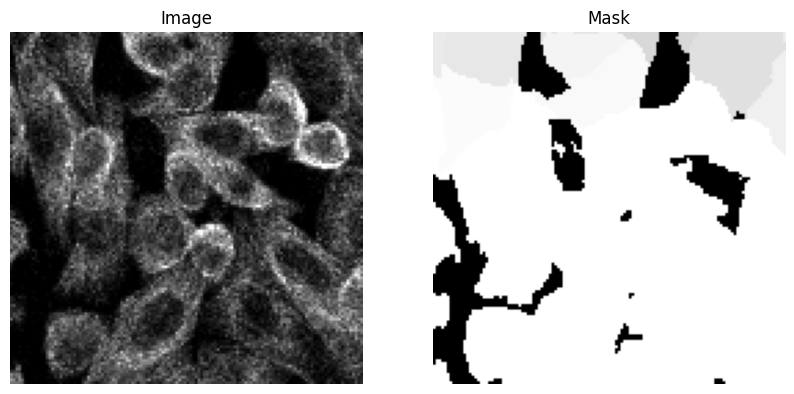

Unique labels in the mask: [  0 216 224 228 231 235 240 244 249 251 255 258 259 264 267 268 270 273
 278 279 285 287 289 292 295 301 304 307 313 314 315 316 318 324 330 333
 334]


In [ ]:
# VALIDATE THAT IMAGES AND MASKS ARE LOADING APPROPRIATELY
import random
import numpy as np
import matplotlib.pyplot as plt

img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale (It is a single color channel)
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='tab20')  # Use a categorical colormap for unique labels
axes[1].set_title("Mask")
axes[1].axis("off")


# Display the images side by side
plt.show()

# Validate unique labels in the mask
unique_labels = np.unique(np.array(example_mask))
print("Unique labels in the mask:", unique_labels)

Generate bounding boxes for ROIs

In [ ]:
# Generates box represented by [x_min, y_min, x_max, y_max] for each cell / ROI

def get_bounding_boxes(ground_truth_map):
    """
    Get bounding boxes for each unique label in an instance mask.

    Args:
        ground_truth_map (np.array): 2D array with unique integer labels for each instance.

    Returns:
        List[List[int]]: A list of bounding boxes for each instance.
                         Each bounding box is represented as [x_min, y_min, x_max, y_max].
    """
    # Find unique labels in the mask (excluding 0, which is background)
    unique_labels = np.unique(ground_truth_map)
    unique_labels = unique_labels[unique_labels > 0]  # Exclude background (label 0)

    bboxes = []

    if len(unique_labels) == 0:
        # If the mask is empty, return a single default bounding box
        return [[0, 0, 1, 1]]

    for label in unique_labels:
        # Get indices for the current instance
        y_indices, x_indices = np.where(ground_truth_map == label)

        # Compute bounding box coordinates
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # Add random perturbations to the bounding box (optional)
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))

        bboxes.append([x_min, y_min, x_max, y_max])

    return bboxes

In [ ]:
from torch.utils.data import Dataset
import numpy as np

# class SAMDataset(Dataset):
#     """
#     This class creates a dataset for SAM, handling instance segmentation masks with unique integer labels.
#     It generates bounding box prompts for each instance in the mask and prepares inputs for the model.
#     """
#     def __init__(self, dataset, processor):
#         self.dataset = dataset
#         self.processor = processor

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         # Retrieve the dataset item
#         item = self.dataset[idx]
#         image = np.array(item["image"])
#         ground_truth_mask = np.array(item["label"])

#         # Ensure the image has 3 dimensions (H, W, C)
#         if image.ndim == 2:  # Grayscale image
#             image = np.expand_dims(image, axis=-1)  # Add a channel dimension (H, W, 1)

#         # Get bounding boxes for all instances in the mask
#         bounding_boxes = get_bounding_boxes(ground_truth_mask)  # List of [x_min, y_min, x_max, y_max]

#         # Prepare the image and bounding boxes for the model
#         inputs = self.processor(image, input_boxes=[bounding_boxes], return_tensors="pt")

#         # Remove batch dimension which the processor adds by default
#         inputs = {k: v.squeeze(0) for k, v in inputs.items()}

#         # Add the ground truth segmentation mask
#         inputs["ground_truth_mask"] = ground_truth_mask

#         return inputs

class SAMDataset(Dataset):
    """
    This class creates a dataset for SAM, handling instance segmentation masks with unique integer labels.
    It generates bounding box prompts for each instance in the mask and prepares inputs for the model.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the dataset item
        item = self.dataset[idx]
        image = np.array(item["image"])
        ground_truth_mask = np.array(item["label"])

        # Ensure the image has 3 dimensions (H, W, C)
        if image.ndim == 2:  # Grayscale image
            image = np.stack([image] * 3, axis=-1)  # Convert to RGB by stacking channels

        # Get bounding boxes for all instances in the mask
        bounding_boxes = get_bounding_boxes(ground_truth_mask)  # List of [x_min, y_min, x_max, y_max]

        # Prepare the image and bounding boxes for the model
        inputs = self.processor(image, input_boxes=[bounding_boxes], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # Add the ground truth segmentation mask
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

# Modify the processor's normalization parameters for RGB images
processor.image_processor.image_mean = [0.5, 0.5, 0.5]  # Mean for 3 channels (R, G, B)
processor.image_processor.image_std = [0.5, 0.5, 0.5]   # Std for 3 channels (R, G, B)

# Test the dataset with a single example
example = train_dataset[0]
for key, value in example.items():
    print(f"{key}: {value.shape if isinstance(value, np.ndarray) or hasattr(value, 'shape') else type(value)}")

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([17, 4])
ground_truth_mask: (128, 128)


In [ ]:
#  Ensures that your training data is batched and ready for processing during model training

# Creating Data Loader
from torch.utils.data import DataLoader

import torch
from torch.nn.utils.rnn import pad_sequence


def custom_collate(batch):
    """
    Custom collate function to handle variable-sized tensors.
    """
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    original_sizes = torch.stack([item["original_sizes"] for item in batch])
    reshaped_input_sizes = torch.stack([item["reshaped_input_sizes"] for item in batch])
    ground_truth_masks = torch.stack([torch.tensor(item["ground_truth_mask"]) for item in batch])

    # Pad input_boxes to the maximum number of boxes in the batch
    input_boxes = [item["input_boxes"].clone().detach() for item in batch]
    input_boxes = pad_sequence(input_boxes, batch_first=True, padding_value=-1)  # Use -1 as padding

    return {
        "pixel_values": pixel_values,
        "original_sizes": original_sizes,
        "reshaped_input_sizes": reshaped_input_sizes,
        "input_boxes": input_boxes,
        "ground_truth_mask": ground_truth_masks,
    }

train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    drop_last=False,
    collate_fn=custom_collate  # Use the custom collate function
)

# Fetching and Inspecting a Batch       (fetches the first batch from the DataLoader)

batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 28, 4])
ground_truth_mask torch.Size([2, 128, 128])


In [ ]:
# Validation
batch["ground_truth_mask"].shape

torch.Size([2, 128, 128])

# Load the SAM Model for Training

In [ ]:
# Load SAM Model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# Freeze Specific Components (Vision and Prompt encoders; only un-freezing the mask decoder)
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

Define the Optimizer and Loss Function (required for the training loop)

In [ ]:
from torch.optim import Adam
import monai

# Initialize the optimizer to fine-tune only the mask decoder
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# Use a multi-class DiceCELoss for instance segmentation
seg_loss = monai.losses.DiceCELoss(
    to_onehot_y=True,  # Converts labels to one-hot encoding
    softmax=True,      # Applies softmax to model outputs for multi-class
    squared_pred=True, # Squares predictions for stability
    reduction='mean'   # Computes the mean loss across the batch
)

In [ ]:
# Sanity check
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

vision_encoder.pos_embed: requires_grad=False
vision_encoder.patch_embed.projection.weight: requires_grad=False
vision_encoder.patch_embed.projection.bias: requires_grad=False
vision_encoder.layers.0.layer_norm1.weight: requires_grad=False
vision_encoder.layers.0.layer_norm1.bias: requires_grad=False
vision_encoder.layers.0.attn.rel_pos_h: requires_grad=False
vision_encoder.layers.0.attn.rel_pos_w: requires_grad=False
vision_encoder.layers.0.attn.qkv.weight: requires_grad=False
vision_encoder.layers.0.attn.qkv.bias: requires_grad=False
vision_encoder.layers.0.attn.proj.weight: requires_grad=False
vision_encoder.layers.0.attn.proj.bias: requires_grad=False
vision_encoder.layers.0.layer_norm2.weight: requires_grad=False
vision_encoder.layers.0.layer_norm2.bias: requires_grad=False
vision_encoder.layers.0.mlp.lin1.weight: requires_grad=False
vision_encoder.layers.0.mlp.lin1.bias: requires_grad=False
vision_encoder.layers.0.mlp.lin2.weight: requires_grad=False
vision_encoder.layers.0.mlp.l

**Main Training Loop**

Current implementation = 10 Epochs

Epoch: One full iteration over the entire dataset.

In [ ]:
# from tqdm import tqdm
# from statistics import mean
# import torch
# import torch.nn.functional as F

# # Training loop
# num_epochs = 10
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# # Enable gradient checkpointing
# model.gradient_checkpointing_enable()

# # Use Mixed Precision Training
# scaler = torch.amp.GradScaler()

# # Reduce batch size
# train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# # Accumulate gradients every 8 steps
# accumulation_steps = 8

# for epoch in range(num_epochs):
#     torch.cuda.empty_cache()
#     epoch_losses = []
#     optimizer.zero_grad()

#     for i, batch in enumerate(tqdm(train_dataloader)):
#         with torch.amp.autocast(device_type="cuda"):
#             outputs = model(
#                 pixel_values=batch["pixel_values"].to(device),  # Move to GPU
#                 input_boxes=batch["input_boxes"].to(device),    # Move to GPU
#                 multimask_output=False
#             )

#             predicted_masks = outputs.pred_masks.squeeze(2)
#             num_classes = predicted_masks.shape[1]

#             ground_truth_mask = batch["ground_truth_mask"].unsqueeze(1).to(device)  # Move to GPU
#             ground_truth_mask = torch.clamp(ground_truth_mask, max=num_classes - 1)

#             loss = seg_loss(predicted_masks, ground_truth_mask)
#             loss = loss / accumulation_steps  # Scale loss for accumulation

#         scaler.scale(loss).backward()

#         if (i + 1) % accumulation_steps == 0 or i == len(train_dataloader) - 1:
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad()

#         epoch_losses.append(loss.item())

#     torch.cuda.empty_cache()  # Clear memory after each epoch

#     print(f"EPOCH {epoch + 1}/{num_epochs}")
#     print(f"Mean loss: {mean(epoch_losses):.4f}")

from tqdm import tqdm
from statistics import mean
import torch
import torch.nn.functional as F

# Training loop
num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

# Use Mixed Precision Training
scaler = torch.amp.GradScaler()

# Reduce batch size
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Accumulate gradients every 8 steps
accumulation_steps = 8

for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    epoch_losses = []
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(train_dataloader)):
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),  # Move to GPU
                input_boxes=batch["input_boxes"].to(device),    # Move to GPU
                multimask_output=False
            )

            # Predicted masks: [batch_size, num_classes, height, width]
            predicted_masks = outputs.pred_masks.squeeze(2)  # Remove extra dimension
            predicted_masks = F.interpolate(predicted_masks, size=(128, 128), mode="bilinear", align_corners=False)

            # Match number of classes between prediction and ground truth
            num_classes = predicted_masks.shape[1]

            # Ground truth mask: [batch_size, 1, height, width]
            ground_truth_mask = batch["ground_truth_mask"].unsqueeze(1).to(device)  # Add channel dimension
            ground_truth_mask = torch.clamp(ground_truth_mask, max=num_classes - 1)

            # Compute loss
            loss = seg_loss(predicted_masks, ground_truth_mask)
            loss = loss / accumulation_steps  # Scale loss for accumulation

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or i == len(train_dataloader) - 1:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        epoch_losses.append(loss.item())

    torch.cuda.empty_cache()  # Clear memory after each epoch

    print(f"EPOCH {epoch + 1}/{num_epochs}")
    print(f"Mean loss: {mean(epoch_losses):.4f}")

 95%|█████████▍| 3908/4116 [08:31<00:26,  7.94it/s]/usr/local/lib/python3.10/dist-packages/monai/losses/dice.py:147: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
/usr/local/lib/python3.10/dist-packages/monai/losses/dice.py:156: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")
100%|██████████| 4116/4116 [08:59<00:00,  7.62it/s]


EPOCH 1/10
Mean loss: 0.4047


100%|██████████| 4116/4116 [09:02<00:00,  7.58it/s]


EPOCH 2/10
Mean loss: 0.2963


100%|██████████| 4116/4116 [09:03<00:00,  7.58it/s]


EPOCH 3/10
Mean loss: 0.2857


100%|██████████| 4116/4116 [08:58<00:00,  7.65it/s]


EPOCH 4/10
Mean loss: 0.2801


100%|██████████| 4116/4116 [08:54<00:00,  7.70it/s]


EPOCH 5/10
Mean loss: 0.2776


100%|██████████| 4116/4116 [08:57<00:00,  7.66it/s]


EPOCH 6/10
Mean loss: 0.2748


100%|██████████| 4116/4116 [08:55<00:00,  7.69it/s]


EPOCH 7/10
Mean loss: 0.2734


100%|██████████| 4116/4116 [08:57<00:00,  7.65it/s]


EPOCH 8/10
Mean loss: 0.2718


100%|██████████| 4116/4116 [08:51<00:00,  7.75it/s]


EPOCH 9/10
Mean loss: 0.2718


100%|██████████| 4116/4116 [08:53<00:00,  7.71it/s]

EPOCH 10/10
Mean loss: 0.2653


In [ ]:
# Save the model's state dictionary to a file
# torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/FirstFineTune.pth")

import os
save_path = "/content/drive/MyDrive/ColabNotebooks/FirstFineTune.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create the directory if it doesn't exist
torch.save(model.state_dict(), save_path)

# Post-Processing, Predictions

<ipython-input-35-c6343f2f0f98>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_mito_model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.cuda

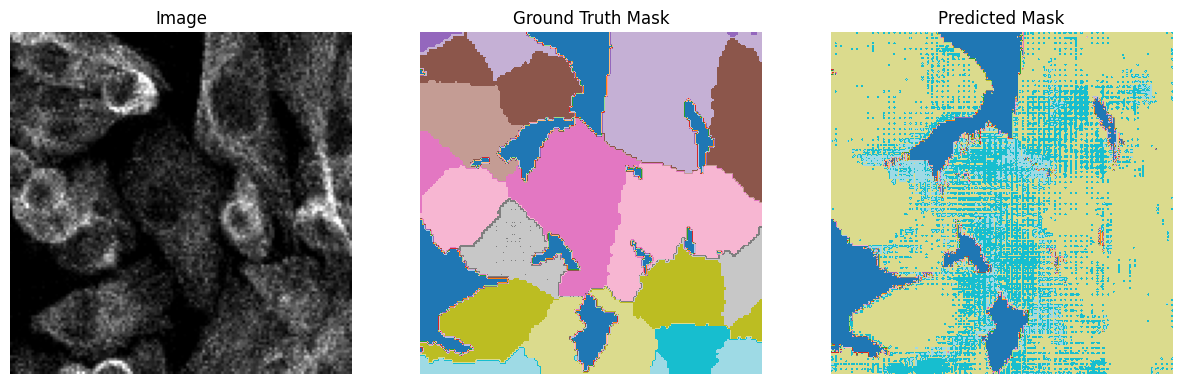

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)

# Update the model by loading the weights from the new fine-tuned file
checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/FirstFineTune.pth"
my_mito_model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))

# Set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

# Set the model to evaluation mode
my_mito_model.eval()

# Take a random example from the dataset
idx = random.randint(0, len(dataset) - 1)  # Ensure the index is within bounds

# Load image and ground truth mask
test_image = dataset[idx]["image"]
ground_truth_mask = np.array(dataset[idx]["label"])

# Convert the image to a NumPy array
test_image = np.array(test_image)

# Ensure the image has 3 dimensions (expand grayscale to 3 channels if needed)
if len(test_image.shape) == 2:  # Check if the image is grayscale
    test_image = np.stack([test_image] * 3, axis=-1)  # Duplicate the channel to make it 3 channels

# Modify the processor's normalization parameters for RGB images
processor.image_processor.image_mean = [0.5, 0.5, 0.5]  # Set mean for 3 channels (RGB)
processor.image_processor.image_std = [0.5, 0.5, 0.5]   # Set std for 3 channels (RGB)

# Get bounding boxes for all instances in the mask
bounding_boxes = get_bounding_boxes(ground_truth_mask)

# Prepare image and bounding box prompts for the model
inputs = processor(test_image, input_boxes=[bounding_boxes], return_tensors="pt")

# Move the input tensor to the GPU if available
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward pass to get predictions
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# Apply softmax to get probabilities for each class
predicted_masks_prob = torch.softmax(outputs.pred_masks, dim=1)  # Shape: (batch_size, num_classes, H, W)

# Convert probabilities to instance labels by taking the argmax
predicted_masks = torch.argmax(predicted_masks_prob, dim=1).cpu().numpy().squeeze()

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the test image
axes[0].imshow(test_image[:, :, 0], cmap="gray")  # Use the first channel for display
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the ground truth mask
axes[1].imshow(ground_truth_mask, cmap="tab20")  # Use tab20 colormap for distinct labels
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

# Plot the predicted mask
axes[2].imshow(predicted_masks, cmap="tab20")  # Use tab20 colormap for distinct labels
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

plt.show()

Compare old SAM and refined SAM

<ipython-input-36-947ab9c9ddd4>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refined_sam_model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.

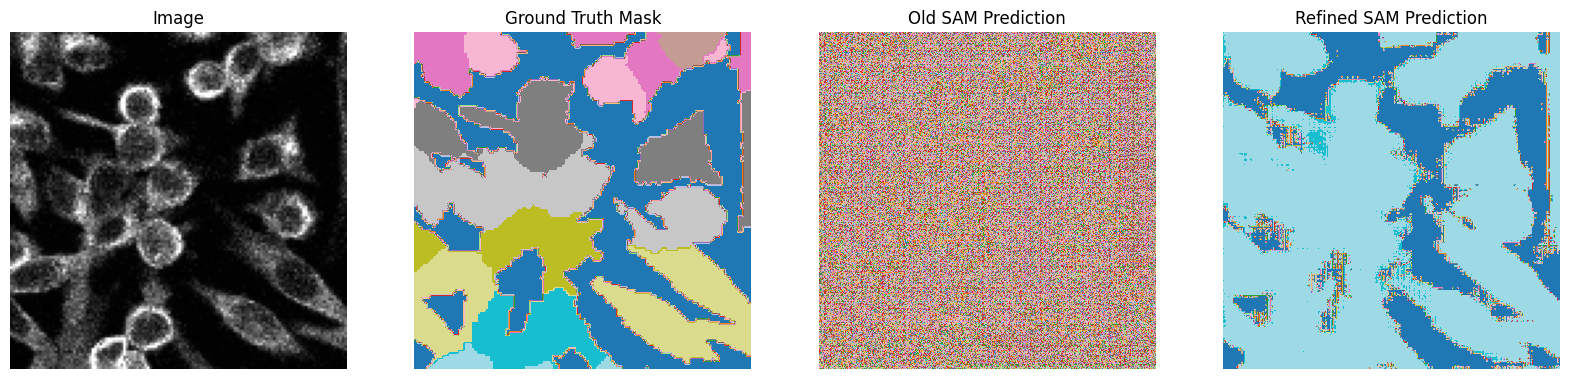

In [ ]:
# Test image with old SAM

from transformers import SamModel, SamConfig, SamProcessor
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

# Load the pre-trained SAM model (old SAM)
old_sam_model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
old_sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
old_sam_model = SamModel(config=old_sam_model_config)

# Load the fine-tuned SAM model (refined SAM)
refined_sam_model = SamModel(config=old_sam_model_config)
checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/FirstFineTune.pth"
refined_sam_model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))

# Set the device to CUDA if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
old_sam_model.to(device)
refined_sam_model.to(device)

# Set both models to evaluation mode
old_sam_model.eval()
refined_sam_model.eval()

# Take a random example from the dataset
idx = random.randint(0, len(dataset) - 1)  # Ensure the index is within bounds

# Load image and ground truth mask
test_image = dataset[idx]["image"]
ground_truth_mask = np.array(dataset[idx]["label"])

# Convert the image to a NumPy array
test_image = np.array(test_image)

# Ensure the image has 3 dimensions (expand grayscale to 3 channels if needed)
if len(test_image.shape) == 2:  # Check if the image is grayscale
    test_image = np.stack([test_image] * 3, axis=-1)  # Duplicate the channel to make it 3 channels

# Modify the processor's normalization parameters for RGB images
old_sam_processor.image_processor.image_mean = [0.5, 0.5, 0.5]
old_sam_processor.image_processor.image_std = [0.5, 0.5, 0.5]
old_inputs = old_sam_processor(test_image, input_boxes=[get_bounding_boxes(ground_truth_mask)], return_tensors="pt")

# Prepare inputs for the fine-tuned SAM
inputs = old_sam_processor(test_image, input_boxes=[get_bounding_boxes(ground_truth_mask)], return_tensors="pt")

# Move the input tensors to the GPU if available
old_inputs = {k: v.to(device) for k, v in old_inputs.items()}
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get predictions from both models
with torch.no_grad():
    old_outputs = old_sam_model(**old_inputs, multimask_output=False)
    refined_outputs = refined_sam_model(**inputs, multimask_output=False)

# Process outputs
old_predicted_masks_prob = torch.softmax(old_outputs.pred_masks, dim=1)
refined_predicted_masks_prob = torch.softmax(refined_outputs.pred_masks, dim=1)

old_predicted_masks = torch.argmax(old_predicted_masks_prob, dim=1).cpu().numpy().squeeze()
refined_predicted_masks = torch.argmax(refined_predicted_masks_prob, dim=1).cpu().numpy().squeeze()

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot the test image
axes[0].imshow(test_image[:, :, 0], cmap="gray")  # Use the first channel for display
axes[0].set_title("Image")
axes[0].axis("off")

# Plot the ground truth mask
axes[1].imshow(ground_truth_mask, cmap="tab20")  # Use tab20 colormap for distinct labels
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

# Plot the old SAM's predicted mask
axes[2].imshow(old_predicted_masks, cmap="tab20")  # Use tab20 colormap for distinct labels
axes[2].set_title("Old SAM Prediction")
axes[2].axis("off")

# Plot the refined SAM's predicted mask
axes[3].imshow(refined_predicted_masks, cmap="tab20")  # Use tab20 colormap for distinct labels
axes[3].set_title("Refined SAM Prediction")
axes[3].axis("off")

plt.show()

# Test refined SAM on a new image

<ipython-input-46-ef3c8957b340>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refined_sam_model.load_state_dict(torch.load(checkpoint_path, map_location=device))


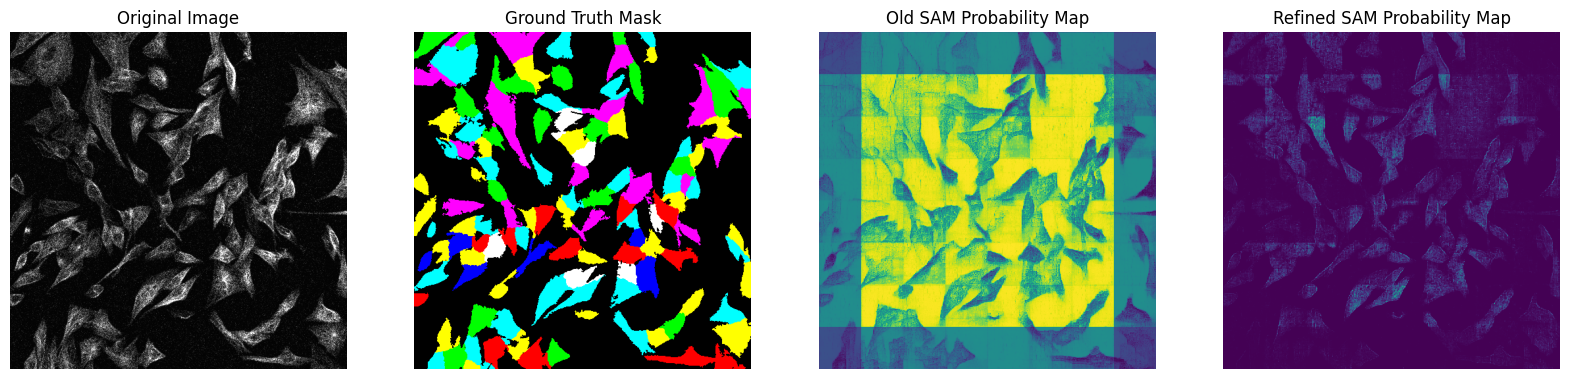

In [ ]:
import tifffile
import numpy as np
import torch
from patchify import patchify
import matplotlib.pyplot as plt
from transformers import SamModel, SamProcessor, SamConfig
import cv2  # For resizing

# Paths
checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/FirstFineTune.pth"  # Refined SAM model
large_image_path = "/content/drive/MyDrive/SAM_Finetuning/Refined_SAM_Testing/testimageone.tif"
ground_truth_mask_path = "/content/drive/MyDrive/SAM_Finetuning/Refined_SAM_Testing/testmaskone.tif"

# Load the large raw image and ground truth mask
large_test_image = tifffile.imread(large_image_path).astype(np.float32)  # Ensure the image is in float32
ground_truth_mask = tifffile.imread(ground_truth_mask_path)

# Normalize the raw image to range [0, 255]
large_test_image = (large_test_image - large_test_image.min()) / (large_test_image.max() - large_test_image.min()) * 255
large_test_image = large_test_image.astype(np.uint8)  # Convert to uint8

# Load the old SAM model and processor
old_sam_model = SamModel.from_pretrained("facebook/sam-vit-base")
old_sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
old_sam_model.to(device)
old_sam_model.eval()

# Load the fine-tuned SAM model
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
refined_sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
refined_sam_model = SamModel(config=model_config)
refined_sam_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
refined_sam_model.to(device)
refined_sam_model.eval()

# Patchify the large image
patch_size = 128
step = 64
patches = patchify(large_test_image, (patch_size, patch_size), step=step)

# Prepare grid points for SAM input
grid_size = 10
x = np.linspace(0, patch_size - 1, grid_size)
y = np.linspace(0, patch_size - 1, grid_size)
xv, yv = np.meshgrid(x, y)
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv, yv)]
input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2).to(device)

# Initialize arrays to store probability maps
reconstructed_height = patches.shape[0] * step + (patch_size - step)
reconstructed_width = patches.shape[1] * step + (patch_size - step)

probability_map_old = np.zeros((reconstructed_height, reconstructed_width), dtype=np.float32)
probability_map_refined = np.zeros((reconstructed_height, reconstructed_width), dtype=np.float32)

# Process patches with both old and refined SAM models
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j]

        # Normalize the patch to range [0, 255]
        patch = (patch - patch.min()) / (patch.max() - patch.min()) * 255
        patch = patch.astype(np.uint8)

        # Convert grayscale patch to RGB
        patch_image = np.stack([patch] * 3, axis=-1)  # Convert grayscale to 3-channel RGB

        # Prepare inputs for both SAM models
        old_inputs = old_sam_processor(patch_image, input_points=input_points.cpu(), return_tensors="pt")
        refined_inputs = refined_sam_processor(patch_image, input_points=input_points.cpu(), return_tensors="pt")
        old_inputs = {k: v.to(device) for k, v in old_inputs.items()}
        refined_inputs = {k: v.to(device) for k, v in refined_inputs.items()}

        # Forward pass
        with torch.no_grad():
            old_outputs = old_sam_model(**old_inputs, multimask_output=False)
            refined_outputs = refined_sam_model(**refined_inputs, multimask_output=False)

        # Extract the raw probability maps
        prob_patch_old = torch.sigmoid(old_outputs.pred_masks[0, 0, 0]).cpu().numpy()  # Single channel
        prob_patch_refined = torch.sigmoid(refined_outputs.pred_masks[0, 0, 0]).cpu().numpy()

        # Resize probability maps to match patch size
        prob_patch_old_resized = cv2.resize(prob_patch_old, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)
        prob_patch_refined_resized = cv2.resize(prob_patch_refined, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)

        # Calculate coordinates in the reconstructed image
        y_start = i * step
        y_end = y_start + patch_size
        x_start = j * step
        x_end = x_start + patch_size

        # Accumulate the probability maps
        probability_map_old[y_start:y_end, x_start:x_end] += prob_patch_old_resized
        probability_map_refined[y_start:y_end, x_start:x_end] += prob_patch_refined_resized

# Normalize the accumulated probability maps for visualization
probability_map_old = (probability_map_old - probability_map_old.min()) / (probability_map_old.max() - probability_map_old.min())
probability_map_refined = (probability_map_refined - probability_map_refined.min()) / (probability_map_refined.max() - probability_map_refined.min())

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Original image
axes[0].imshow(large_test_image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Ground truth mask
axes[1].imshow(ground_truth_mask, cmap="tab20")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

# Old SAM probability map
axes[2].imshow(probability_map_old, cmap="viridis")  # Use a smooth colormap like viridis
axes[2].set_title("Old SAM Probability Map")
axes[2].axis("off")

# Refined SAM probability map
axes[3].imshow(probability_map_refined, cmap="viridis")
axes[3].set_title("Refined SAM Probability Map")
axes[3].axis("off")

plt.show()

# Blue in matplotlib plots often corresponds to class 0 (background or the absence of segmentation).

1. Color Scale
The color map used for displaying the probability map is a viridis-like colormap, where:
Dark Blue: Represents the lowest confidence values (near 0 probability).
Yellow: Represents the highest confidence values (near 1 probability).
This is a continuous range where intermediate colors (e.g., green, teal) represent probabilities between the extremes.

# Debugging Code

In [ ]:
# Debugging: Print input points
print("Input points:", input_points)

# Process patches with both old and refined SAM models
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j]

        # Normalize the patch to range [0, 255]
        patch = (patch - patch.min()) / (patch.max() - patch.min()) * 255
        patch = patch.astype(np.uint8)

        # Convert grayscale patch to RGB
        patch_image = np.stack([patch] * 3, axis=-1)  # Convert grayscale to 3-channel RGB

        # Prepare inputs for both SAM models
        old_inputs = old_sam_processor(patch_image, input_points=input_points.cpu(), return_tensors="pt")
        refined_inputs = refined_sam_processor(patch_image, input_points=input_points.cpu(), return_tensors="pt")
        old_inputs = {k: v.to(device) for k, v in old_inputs.items()}
        refined_inputs = {k: v.to(device) for k, v in refined_inputs.items()}

        # Forward pass
        with torch.no_grad():
            old_outputs = old_sam_model(**old_inputs, multimask_output=False)
            refined_outputs = refined_sam_model(**refined_inputs, multimask_output=False)

        # Debugging: Print model outputs
        print(f"Patch ({i}, {j}) - Old SAM outputs:")
        print("Old SAM pred_masks shape:", old_outputs.pred_masks.shape)
        print("Old SAM pred_masks unique values:", torch.unique(old_outputs.pred_masks))

        print(f"Patch ({i}, {j}) - Refined SAM outputs:")
        print("Refined SAM pred_masks shape:", refined_outputs.pred_masks.shape)
        print("Refined SAM pred_masks unique values:", torch.unique(refined_outputs.pred_masks))

        # Process outputs
        predicted_patch_old = torch.argmax(torch.softmax(old_outputs.pred_masks, dim=1), dim=1).cpu().numpy().squeeze()
        predicted_patch_refined = torch.argmax(torch.softmax(refined_outputs.pred_masks, dim=1), dim=1).cpu().numpy().squeeze()

        # Resize outputs to match patch size
        predicted_patch_old_resized = cv2.resize(predicted_patch_old, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)
        predicted_patch_refined_resized = cv2.resize(predicted_patch_refined, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)

        # Calculate coordinates in the reconstructed image
        y_start = i * step
        y_end = y_start + patch_size
        x_start = j * step
        x_end = x_start + patch_size

        # Store the resized patches in the reconstructed image arrays
        segmented_image_old[y_start:y_end, x_start:x_end] = predicted_patch_old_resized
        segmented_image_refined[y_start:y_end, x_start:x_end] = predicted_patch_refined_resized

Input points: tensor([[[[  0,   0],
          [ 14,   0],
          [ 28,   0],
          [ 42,   0],
          [ 56,   0],
          [ 70,   0],
          [ 84,   0],
          [ 98,   0],
          [112,   0],
          [127,   0],
          [  0,  14],
          [ 14,  14],
          [ 28,  14],
          [ 42,  14],
          [ 56,  14],
          [ 70,  14],
          [ 84,  14],
          [ 98,  14],
          [112,  14],
          [127,  14],
          [  0,  28],
          [ 14,  28],
          [ 28,  28],
          [ 42,  28],
          [ 56,  28],
          [ 70,  28],
          [ 84,  28],
          [ 98,  28],
          [112,  28],
          [127,  28],
          [  0,  42],
          [ 14,  42],
          [ 28,  42],
          [ 42,  42],
          [ 56,  42],
          [ 70,  42],
          [ 84,  42],
          [ 98,  42],
          [112,  42],
          [127,  42],
          [  0,  56],
          [ 14,  56],
          [ 28,  56],
          [ 42,  56],
          [ 56,  5

In [ ]:
print("Number of classes (old SAM):", old_outputs.pred_masks.shape[1])
print("Number of classes (refined SAM):", refined_outputs.pred_masks.shape[1])

Number of classes (old SAM): 1
Number of classes (refined SAM): 1


Steps to Convert a Probability Map to a Mask
The probability map represents the likelihood of each pixel belonging to different classes. To create a mask, you can use thresholding.

In [ ]:
threshold = 0.5  # Set threshold (e.g., 50% probability)
binary_mask = (probability_map > threshold).astype(np.uint8)  # Binary mask (1 for pixels above threshold)

# Generating Threshold Masks as TIFF

<ipython-input-21-ec6e43972757>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refined_sam_model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.

Refined binary mask saved to: /content/refined_cleaned_binary_mask.tif


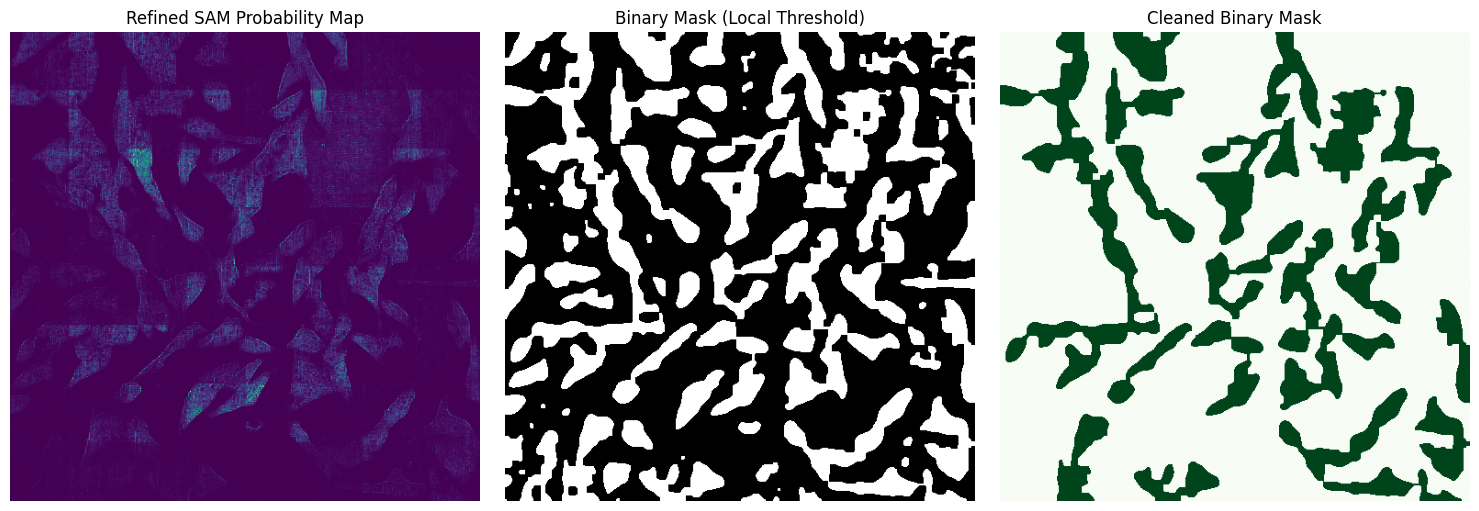

In [ ]:
!pip install patchify

import tifffile
import numpy as np
import torch
from patchify import patchify
import matplotlib.pyplot as plt
from transformers import SamModel, SamProcessor, SamConfig
import cv2  # For resizing
from skimage.morphology import remove_small_objects, binary_opening, binary_closing
from skimage.filters import gaussian, threshold_otsu, threshold_local
from scipy.ndimage import binary_fill_holes

# Paths
checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/FirstFineTune.pth"  # Refined SAM model
large_image_path = "/content/drive/MyDrive/SAM_Finetuning/Refined_SAM_Testing/testimageone.tif"

# Load the large raw image
large_test_image = tifffile.imread(large_image_path).astype(np.float32)  # Ensure the image is in float32

# Normalize the raw image to range [0, 255]
large_test_image = (large_test_image - large_test_image.min()) / (large_test_image.max() - large_test_image.min()) * 255
large_test_image = large_test_image.astype(np.uint8)  # Convert to uint8

# Load the fine-tuned SAM model
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
refined_sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
refined_sam_model = SamModel(config=model_config)
refined_sam_model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
device = "cuda" if torch.cuda.is_available() else "cpu"
refined_sam_model.to(device)
refined_sam_model.eval()

# Patchify the large image
patch_size = 128
step = 64
patches = patchify(large_test_image, (patch_size, patch_size), step=step)

# Prepare grid points for SAM input
grid_size = 10
x = np.linspace(0, patch_size - 1, grid_size)
y = np.linspace(0, patch_size - 1, grid_size)
xv, yv = np.meshgrid(x, y)
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv, yv)]
input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2).to(device)

# Initialize array to store the probability map
reconstructed_height = patches.shape[0] * step + (patch_size - step)
reconstructed_width = patches.shape[1] * step + (patch_size - step)
probability_map_refined = np.zeros((reconstructed_height, reconstructed_width), dtype=np.float32)

# Process patches with the refined SAM model
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j]

        # Normalize the patch to range [0, 255]
        patch = (patch - patch.min()) / (patch.max() - patch.min()) * 255
        patch = patch.astype(np.uint8)

        # Convert grayscale patch to RGB
        patch_image = np.stack([patch] * 3, axis=-1)  # Convert grayscale to 3-channel RGB

        # Prepare inputs for the refined SAM model
        refined_inputs = refined_sam_processor(patch_image, input_points=input_points.cpu(), return_tensors="pt")
        refined_inputs = {k: v.to(device) for k, v in refined_inputs.items()}

        # Forward pass
        with torch.no_grad():
            refined_outputs = refined_sam_model(**refined_inputs, multimask_output=False)

        # Extract the raw probability map
        prob_patch_refined = torch.sigmoid(refined_outputs.pred_masks[0, 0, 0]).cpu().numpy()

        # Resize the probability map to match the patch size
        prob_patch_refined_resized = cv2.resize(prob_patch_refined, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)

        # Calculate coordinates in the reconstructed image
        y_start = i * step
        y_end = y_start + patch_size
        x_start = j * step
        x_end = x_start + patch_size

        # Accumulate the probability map
        probability_map_refined[y_start:y_end, x_start:x_end] += prob_patch_refined_resized

# Smooth the probability map using Gaussian filtering
smoothed_map = gaussian(probability_map_refined, sigma=3)  # Adjust sigma for more or less smoothing

# Use local thresholding for finer segmentation
block_size = 75  # Define the block size for local thresholding
local_thresh = threshold_local(smoothed_map, block_size=block_size)
binary_mask_local = smoothed_map > local_thresh

# Perform morphological operations iteratively for better cleanup
for _ in range(2):  # Iterative binary opening
    binary_mask_local = binary_opening(binary_mask_local, footprint=np.ones((3, 3)))

for _ in range(2):  # Iterative binary closing
    binary_mask_local = binary_closing(binary_mask_local, footprint=np.ones((7, 7)))

# Fill holes in the binary mask
binary_mask_filled = binary_fill_holes(binary_mask_local)

# Remove small objects
binary_mask_final = remove_small_objects(binary_mask_filled, min_size=1500)

# Scale the cleaned binary mask to 0-255 for saving
scaled_binary_mask = (binary_mask_final * 255).astype(np.uint8)

# Save the cleaned binary mask as a TIF file
output_path = "/content/refined_cleaned_binary_mask.tif"
tifffile.imwrite(output_path, scaled_binary_mask)
print(f"Refined binary mask saved to: {output_path}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Refined SAM Probability Map
axes[0].imshow(probability_map_refined, cmap="viridis")
axes[0].set_title("Refined SAM Probability Map")
axes[0].axis("off")

# Binary Mask after Thresholding
axes[1].imshow(binary_mask_local, cmap="gray")
axes[1].set_title("Binary Mask (Local Threshold)")
axes[1].axis("off")

# Cleaned Binary Mask
axes[2].imshow(binary_mask_final, cmap="Greens")
axes[2].set_title("Cleaned Binary Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()

Explanation of Additions:
Morphological Opening:

Removes noise (small isolated pixels) from the mask.
Morphological Closing:

Fills small holes within the cell shapes, creating smoother boundaries.
Connected Component Analysis:

Removes small, disconnected regions (artifacts).
Scaling for Saving:

Scales the mask to 0-255 for visibility in TIF viewers.
Output:
The refined binary mask should now focus on major cell blocks with fewer artifacts.
The mask is scaled to 0-255 for better visualization in the saved TIF file.

<ipython-input-22-017f01dec527>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refined_sam_model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.

Cleaned binary mask saved to: /content/cleaned_binary_mask.tif


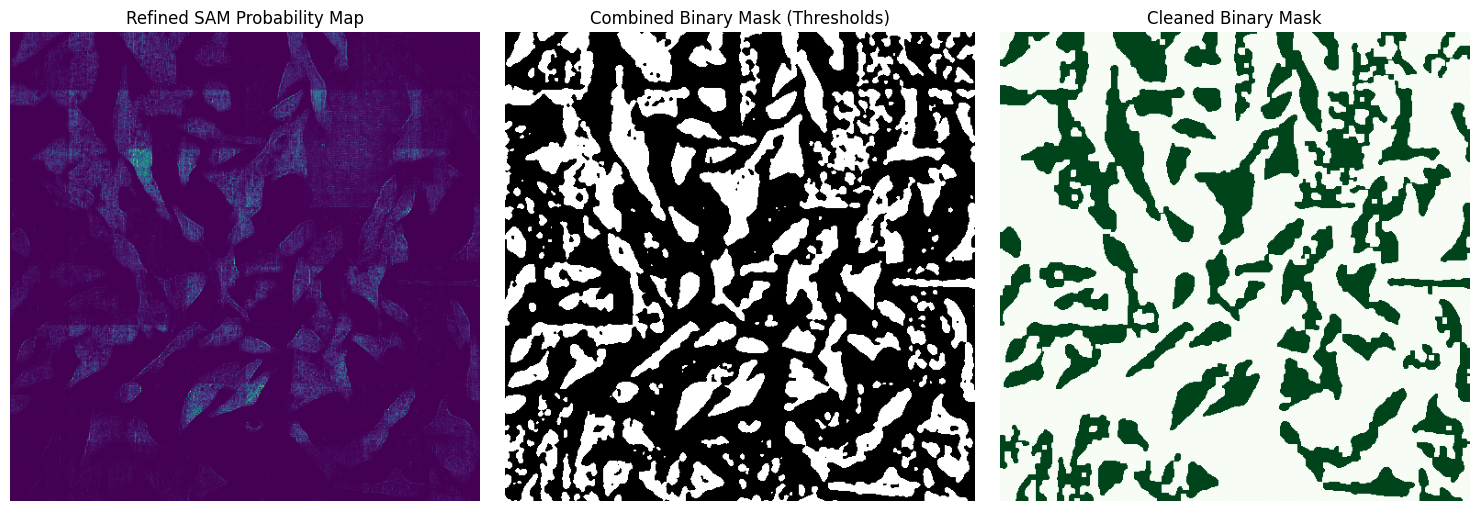

In [ ]:
!pip install patchify

import tifffile
import numpy as np
import torch
from patchify import patchify
import matplotlib.pyplot as plt
from transformers import SamModel, SamProcessor, SamConfig
import cv2  # For resizing
from skimage.morphology import remove_small_objects, binary_opening, binary_closing
from skimage.filters import gaussian, threshold_otsu, threshold_local

# Paths
checkpoint_path = "/content/drive/MyDrive/ColabNotebooks/FirstFineTune.pth"  # Refined SAM model
large_image_path = "/content/drive/MyDrive/SAM_Finetuning/Refined_SAM_Testing/testimageone.tif"

# Load the large raw image
large_test_image = tifffile.imread(large_image_path).astype(np.float32)  # Ensure the image is in float32

# Normalize the raw image to range [0, 255]
large_test_image = (large_test_image - large_test_image.min()) / (large_test_image.max() - large_test_image.min()) * 255
large_test_image = large_test_image.astype(np.uint8)  # Convert to uint8

# Load the fine-tuned SAM model
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
refined_sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
refined_sam_model = SamModel(config=model_config)
refined_sam_model.load_state_dict(torch.load(checkpoint_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
device = "cuda" if torch.cuda.is_available() else "cpu"
refined_sam_model.to(device)
refined_sam_model.eval()

# Patchify the large image
patch_size = 128
step = 64
patches = patchify(large_test_image, (patch_size, patch_size), step=step)

# Prepare grid points for SAM input
grid_size = 10
x = np.linspace(0, patch_size - 1, grid_size)
y = np.linspace(0, patch_size - 1, grid_size)
xv, yv = np.meshgrid(x, y)
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv, yv)]
input_points = torch.tensor(input_points).view(1, 1, grid_size * grid_size, 2).to(device)

# Initialize array to store the probability map
reconstructed_height = patches.shape[0] * step + (patch_size - step)
reconstructed_width = patches.shape[1] * step + (patch_size - step)
probability_map_refined = np.zeros((reconstructed_height, reconstructed_width), dtype=np.float32)

# Process patches with the refined SAM model
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch = patches[i, j]

        # Normalize the patch to range [0, 255]
        patch = (patch - patch.min()) / (patch.max() - patch.min()) * 255
        patch = patch.astype(np.uint8)

        # Convert grayscale patch to RGB
        patch_image = np.stack([patch] * 3, axis=-1)  # Convert grayscale to 3-channel RGB

        # Prepare inputs for the refined SAM model
        refined_inputs = refined_sam_processor(patch_image, input_points=input_points.cpu(), return_tensors="pt")
        refined_inputs = {k: v.to(device) for k, v in refined_inputs.items()}

        # Forward pass
        with torch.no_grad():
            refined_outputs = refined_sam_model(**refined_inputs, multimask_output=False)

        # Extract the raw probability map
        prob_patch_refined = torch.sigmoid(refined_outputs.pred_masks[0, 0, 0]).cpu().numpy()

        # Resize the probability map to match the patch size
        prob_patch_refined_resized = cv2.resize(prob_patch_refined, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)

        # Calculate coordinates in the reconstructed image
        y_start = i * step
        y_end = y_start + patch_size
        x_start = j * step
        x_end = x_start + patch_size

        # Accumulate the probability map
        probability_map_refined[y_start:y_end, x_start:x_end] += prob_patch_refined_resized

# Smooth the probability map using Gaussian filtering
smoothed_map = gaussian(probability_map_refined, sigma=2)  # Adjust sigma for more or less smoothing

# Use Otsu's method to find a global threshold
global_thresh = threshold_otsu(smoothed_map)

# Apply the global threshold to get an initial binary mask
binary_mask_global = smoothed_map > global_thresh

# Use local thresholding for finer segmentation
block_size = 51  # Define the block size for local thresholding
local_thresh = threshold_local(smoothed_map, block_size=block_size)
binary_mask_local = smoothed_map > local_thresh

# Combine global and local masks
combined_mask = binary_mask_global | binary_mask_local

# Perform morphological operations to clean up the mask
binary_mask_cleaned = binary_opening(combined_mask, footprint=np.ones((3, 3)))  # Remove small artifacts
binary_mask_cleaned = binary_closing(binary_mask_cleaned, footprint=np.ones((5, 5)))  # Fill small gaps
binary_mask_cleaned = remove_small_objects(binary_mask_cleaned, min_size=500)  # Remove small connected components

# Scale the cleaned binary mask to 0-255 for saving
scaled_binary_mask = (binary_mask_cleaned * 255).astype(np.uint8)

# Save the cleaned binary mask as a TIF file
output_path = "/content/cleaned_binary_mask.tif"
tifffile.imwrite(output_path, scaled_binary_mask)
print(f"Cleaned binary mask saved to: {output_path}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Refined SAM Probability Map
axes[0].imshow(probability_map_refined, cmap="viridis")
axes[0].set_title("Refined SAM Probability Map")
axes[0].axis("off")

# Combined Binary Mask
axes[1].imshow(combined_mask, cmap="gray")
axes[1].set_title("Combined Binary Mask (Thresholds)")
axes[1].axis("off")

# Cleaned Binary Mask
axes[2].imshow(binary_mask_cleaned, cmap="Greens")
axes[2].set_title("Cleaned Binary Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()

What to fix:
- Change RGB algorithm
- Change training to account for